In [1]:
# Make my plots pretty!
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# SVM Bagging No. 2

This time, output bigram representations, and other vectors, and paste them to the SVM.

We're getting to the ~1000s of features with this, so linear SVMs are probably the only things that are fast enough to prototype with locally.

In [2]:
# Save these files so I don't have to do this again
import csv
def load_tokenized(path):
    with open(path, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        sentences = []
        for row in reader:
            sentences.append(row)
        return sentences

q1_word_tokenized = load_tokenized('../data/train_q1.txt')
q2_word_tokenized = load_tokenized('../data/train_q2.txt')

In [3]:
is_duplicate = [int(x.strip()) for x in open('../data/train_is_duplicate.txt')]
print(is_duplicate[3355:3365])
assert(len(q1_word_tokenized) == len(q2_word_tokenized))
assert(len(q1_word_tokenized) == len(is_duplicate))

[1, 0, 0, 0, 0, 1, 0, 1, 1, 1]


In [4]:
# Some cleaning.
from nltk.corpus import stopwords
from itertools import izip
stop_words = stopwords.words('english')
clean = []
for q1, q2, is_dup in izip(q1_word_tokenized, q2_word_tokenized, is_duplicate):
    # No word that isn't in stop_words exists in q1/q2
    if len(q1) == 0 or len(q2) == 0:
        continue
    if not any((word not in stop_words) for word in q1):
        continue
    if not any((word not in stop_words) for word in q2):
        continue
    clean.append((q1, q2, is_dup))

In [5]:
print(len(clean))
print(len(q1_word_tokenized) - len(clean)) # Examples that were dropped

404270
18


In [6]:
# So we don't have to do this again.
import pickle
pickle.dump(clean, open('../data/train_clean.pickle', 'wb'))

In [9]:
import numpy as np

def load_embeddings(filepath):
    embeddings = {}
    current_word = 0
    rows = []
    
    with open(filepath, "rb") as f:
        for line in f:
            line = line.decode("utf-8")
            elements = line.strip().split(' ', 1)
            word = elements[0]
            vector = [float(x) for x in elements[1].split(' ')]
            vector = np.array(vector)
            
            word_id = current_word
            current_word += 1
            embeddings[word] = word_id
            rows.append(vector)
    return embeddings, np.stack(rows, axis=0)

# Reduce to 100d, to speed things up
dictionary, embed = load_embeddings("../data/glove.6B.100d.txt")
print(embed.shape)

(400000, 100)


# Making Vectors

Now to the meat of this notebook. The goal is: given some sentences, give out a vector. Let's try a few things:
1. Elementwise multiplication of GloVEs
1. Bigrams
1. Permutation testing p-values
1. Fixed-variance Gaussian KL divergence

In [10]:
indices = range(len(clean))
np.random.shuffle(indices)

# 400k sentences is way too many. I'll just pull 20k out for now.
ind_train = indices[:20000]
ind_valid = indices[:5000]

train_set = [clean[i] for i in ind_train]
valid_set = [clean[i] for i in ind_valid]

In [11]:
pickle.dump(train_set, open('../data/train_small.pickle', 'wb'))
pickle.dump(valid_set, open('../data/valid_small.pickle', 'wb'))

In [12]:
train_set = pickle.load(open('../data/train_small.pickle', 'r'))
valid_set = pickle.load(open('../data/valid_small.pickle', 'r'))
print(len(train_set))
print(len(valid_set))

20000
5000


In [13]:
def get_word_embedding(word, dictionary=dictionary, embeddings=embed):
    if word not in dictionary:
        return None
    we = embeddings[dictionary[word]]
    return we

def get_paragraph_embedding(paragraph,
                            dictionary=dictionary,
                            embeddings=embed):
    '''Return a paragraph embedding as an average of its word embeddings.'''
    embedding_size = embeddings[dictionary['the'],:].shape[0] # autodetect
    paragraph_embedding = np.zeros(embedding_size)
    count_words = 0
    for word in paragraph:
        # Assumes all words are <unk> or known
        we = get_word_embedding(word, dictionary, embeddings)
        if we is None:
            continue
        we = embeddings[dictionary[word]]
        paragraph_embedding += we
        count_words += 1
    if count_words > 0:
        paragraph_embedding = paragraph_embedding / count_words
    return paragraph_embedding

assert get_word_embedding('kkkzzzzkkk') is None
assert get_word_embedding('<unk>') is None
get_paragraph_embedding(clean[1000][1])[:50]

array([-0.19323   ,  0.47155267,  0.46280189, -0.51904833, -0.33883344,
        0.11256942, -0.35993444,  0.00517356,  0.36675822, -0.016905  ,
        0.383027  , -0.08791744,  0.04717378,  0.08049889,  0.17580411,
       -0.06370889,  0.38016677,  0.39408556, -0.29445511,  0.47534774,
        0.10885723, -0.09222278,  0.24801656, -0.02334778,  0.09552122,
       -0.05821111,  0.00829816, -0.57296897,  0.38990644, -0.03704922,
        0.23301122,  0.76168333, -0.40961689,  0.06653451,  0.14679411,
        0.26177256, -0.07552067, -0.00112589,  0.23133244, -0.477958  ,
       -0.149857  , -0.45458889, -0.35339967, -0.51174989, -0.62457444,
       -0.00449867,  0.07069133, -0.36442   , -0.14602323, -0.79700578])

In [ ]:
def three_way(v1, v2):
    return np.concatenate([v1, v2, v1 * v2])

def vector_multiply(q1, q2):
    glove_q1 = get_paragraph_embedding(q1)
    glove_q2 = get_paragraph_embedding(q2)
    return three_way(glove_q1, glove_q2)
vector_multiply(clean[1000][0], clean[1000][1]).shape

In [377]:
pq1 = np.zeros(1000)
pq2 = np.zeros(1000)
dist = np.zeros(1000)
base = np.zeros(1000)
mex = np.zeros(1000)

def distance(combination, len_q1):
    global pq1, pq2, dist
    
    pq1 *= 0
    sz = combination[0].shape[0]
    for c in combination[:len_q1]:
        pq1[:sz] += c
    pq1 /= len_q1
    pq2 *= 0
    for c in combination[len_q1:]:
        pq2[:sz] += c
    pq2 /= (len(combination) - len_q1)

    pq1 -= pq2
    np.absolute(pq1, dist)
    
def gwe2(q):
    v = get_word_embedding(q)
    if v is None:
        return None
    return np.concatenate([v, np.square(v)])

def vector_permute(q1, q2, tries=100, seed=72):
    global base, mex
    
    not_none = lambda x: not x is None
    words_q1 = filter(not_none, [gwe2(q) for q in q1])
    words_q2 = filter(not_none, [gwe2(q) for q in q2])
    len_q1 = len(words_q1)
    len_q2 = len(words_q2)
    
    combination = words_q1 + words_q2
    sz = combination[0].shape[0]
    
    # Does a permutation test on the word features.
    more_extreme = np.zeros(sz)
    distance(combination, len_q1)
    base[:] = dist[:]
    np.random.seed(seed)
    for i in xrange(tries):
        np.random.shuffle(combination)
        distance(combination, len_q1)
        np.greater(dist, base, mex)
        more_extreme += mex[:sz]
    more_extreme /= tries
    return more_extreme
try_me = 2
vector_permute(clean[try_me][0], clean[try_me][1])

array([ 0.75,  0.97,  0.79,  0.41,  0.88,  0.94,  0.87,  0.52,  0.69,
        0.3 ,  0.82,  0.78,  0.32,  0.43,  0.43,  0.53,  0.68,  0.68,
        0.54,  0.32,  0.47,  0.9 ,  0.14,  0.09,  0.95,  0.8 ,  0.81,
        0.46,  0.91,  0.59,  0.91,  0.84,  0.59,  0.84,  0.52,  0.37,
        0.71,  0.07,  0.07,  0.86,  0.94,  0.65,  0.08,  0.53,  0.68,
        0.89,  0.78,  0.66,  0.41,  0.52,  0.85,  0.25,  0.28,  0.58,
        0.92,  0.33,  0.56,  0.67,  0.75,  0.89,  0.56,  0.78,  0.91,
        0.84,  0.79,  0.84,  0.75,  0.95,  0.26,  0.84,  0.39,  0.34,
        0.54,  0.6 ,  0.96,  0.13,  0.82,  0.32,  0.76,  0.58,  0.51,
        0.65,  0.92,  0.61,  0.63,  0.89,  0.29,  0.5 ,  0.23,  0.81,
        0.61,  0.44,  0.46,  0.99,  0.41,  0.46,  0.74,  0.73,  0.49,
        0.66,  0.96,  0.94,  0.64,  0.58,  0.8 ,  0.78,  0.79,  0.15,
        0.52,  0.24,  0.51,  0.86,  0.05,  0.39,  0.51,  0.07,  0.87,
        0.52,  0.9 ,  0.15,  0.54,  0.72,  0.39,  0.03,  0.58,  0.9 ,
        0.07,  0.84,

In [96]:
strat = lambda x, y: x * y

def get_bigrams(q):
    words = [get_word_embedding(w) for w in q]
    words = filter(lambda x: not x is None, words)
    no_word = np.zeros(words[0].shape[0])
    yield strat(no_word, words[0])
    for i, word in enumerate(words[:-1]):
        yield strat(word, words[i + 1])
        
def avg_bigrams(q):
    sumbigrams = sum(get_bigrams(q))
    if len(q) == 0:
        return sumbigrams
    return sumbigrams / len(q)

def concat_bigrams(q1, q2):
    bigq1 = avg_bigrams(q1)
    bigq2 = avg_bigrams(q2)
    return three_way(bigq1, bigq2)

concat_bigrams(clean[try_me][0], clean[try_me][1]).shape

(300,)

# Back to SVMs

In [191]:
# Each template is a function from q1, q2 -> 1D vector
basic = [vector_multiply]

def vectorize(dataset, templates, reverse=False):
    X = []
    i = 0
    for q1, q2, is_dup in dataset:
        i += 1
        if i % 2000 == 0:
            print(i)
        if reverse:
            q = q1
            q2 = q1
            q1 = q2
        X.append(np.concatenate([t(q1, q2) for t in templates]))
    X = np.stack(X, axis=0)
    return X

X_train = vectorize(train_set, basic)
X_valid = vectorize(valid_set, basic)
y_train = np.array([t[2] for t in train_set])
y_valid = np.array([t[2] for t in valid_set])
print(X_train.shape)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
2000
4000
(20000, 300)


In [73]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

nrm = Normalizer()
X_train_n = nrm.fit_transform(X_train)
X_valid_n = nrm.transform(X_valid)

In [164]:
bag_num = 100
examples_per_bag = 1000
models = []

C=0.2
indices = range(len(X_train))
for i in range(bag_num):
    np.random.shuffle(indices)
    i_bag = indices[:examples_per_bag]
    print('Model:', i, i_bag[:10])
    X_bag = X_train_n[i_bag]
    y_bag = y_train[i_bag]
    svm = LinearSVC()
    svm.fit(X_bag, y_bag)
    models.append(svm)

Model: 0 [17914, 4232, 19226, 13422, 15281, 2116, 2468, 15879, 6209, 19911]
Model: 1 [12194, 17207, 7900, 514, 16194, 19738, 200, 15654, 15684, 18505]
Model: 2 [927, 9639, 18500, 17303, 7134, 12534, 5623, 4783, 5345, 13555]
Model: 3 [7984, 17137, 13517, 13429, 1498, 3293, 17724, 10438, 18568, 8042]
Model: 4 [3578, 11261, 9532, 19318, 2531, 8923, 13940, 1590, 5559, 7237]
Model: 5 [3112, 17931, 19211, 9979, 11541, 1110, 4154, 8806, 3790, 8710]
Model: 6 [12791, 6050, 5104, 10132, 9650, 2352, 3762, 18121, 19089, 5424]
Model: 7 [7084, 18948, 10418, 16929, 15799, 11090, 4731, 14996, 1776, 7579]
Model: 8 [18156, 15341, 12833, 7826, 1573, 6115, 18216, 6404, 3833, 4962]
Model: 9 [13171, 13146, 9850, 5215, 3000, 50, 6184, 6240, 14758, 3155]
Model: 10 [2137, 10857, 10900, 3722, 17482, 15193, 17820, 15211, 5532, 15904]
Model: 11 [12344, 18382, 6078, 19109, 18004, 2907, 17399, 6210, 6283, 7087]
Model: 12 [4186, 10726, 19355, 7779, 194, 17315, 42, 10242, 6826, 11361]
Model: 13 [178, 1230, 15429, 755

In [198]:
from sklearn.metrics import roc_curve, roc_auc_score
    
# Evaluate.
def evaluate(y, decision_fn, title):
    '''n - how many SVMs to average over'''
    fpr, tpr, thresholds = roc_curve(y_valid, decision_fn)
    auc = roc_auc_score(y, decision_fn)
    print(title + ' AUC: {0}'.format(auc))
    plt.plot(fpr, tpr, label=title)
    return auc

def evaluate_model(models, X_valid, y_valid, title='', ns=[1, 2, 5, 10, 20, 50, 100]):
    decision_one = lambda svm, x: svm.decision_function(x)
    decisions_array = np.stack([decision_one(svm, X_valid) for svm in models], axis=1)
    evaluate_results(decisions_array, y_valid, title=title, ns=ns)
    
def evaluate_results(decisions_array, y_valid, title='', ns=[1, 2, 5, 10, 20, 50, 100]):
    plt.figure(figsize=(4,4))
    
    plt.title('ROC curve: ' + title)
    aucs = []
    for n in ns:
        # n = how many SVMs to average over
        decision_fn = np.mean(decisions_array[:,:n], axis=1)
        aucs.append(evaluate(y_valid, decision_fn, 'avgN={0}'.format(n)))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.plot(ns, aucs)
    plt.title('AUC after averaging')
    plt.xlabel('Num. of SVM models being averaged')
    plt.ylabel('AUC score')
    plt.show()


avgN=1 AUC: 0.673033311123
avgN=2 AUC: 0.693867461023
avgN=5 AUC: 0.71240147044
avgN=10 AUC: 0.717251534974
avgN=20 AUC: 0.72000499911
avgN=50 AUC: 0.7219888273
avgN=100 AUC: 0.721829295882


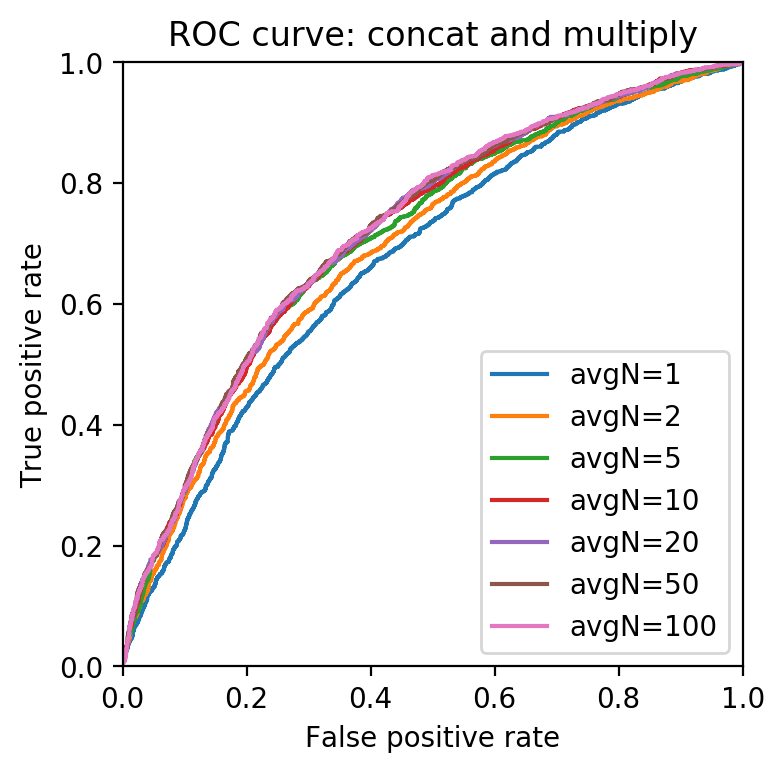

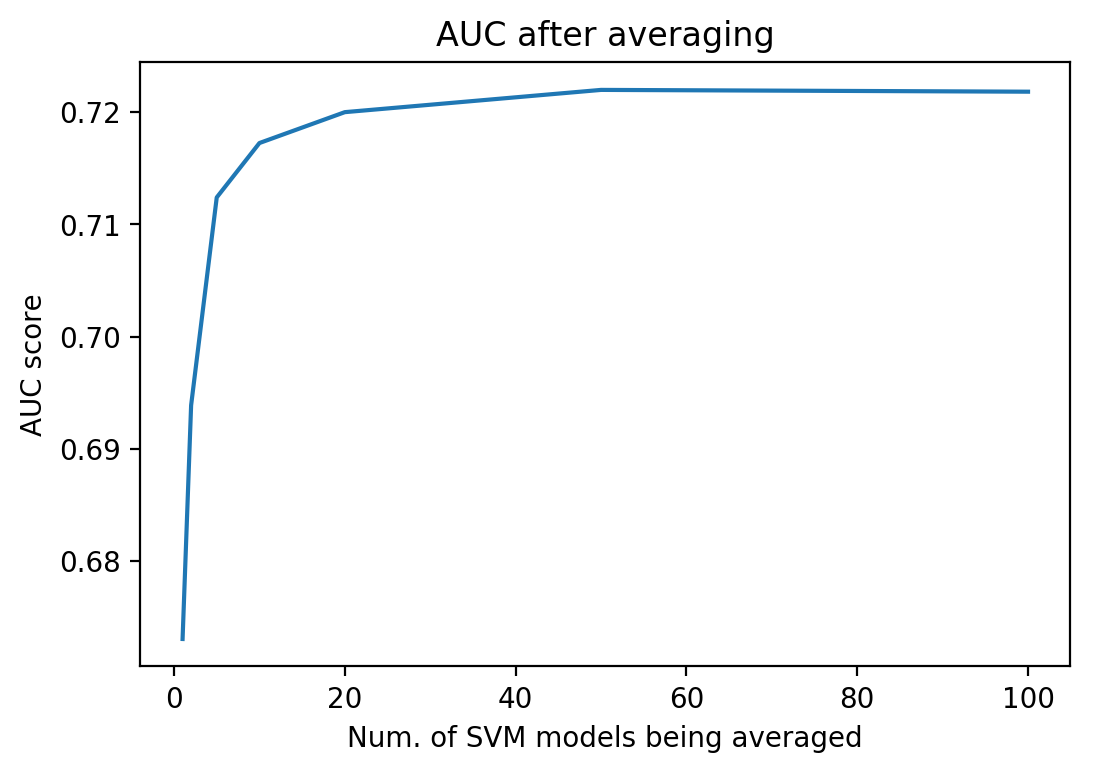

In [199]:
evaluate_model(models, X_valid_n, y_valid, 'concat and multiply')

# Add Bigrams

In [97]:
bigrams = [vector_multiply, concat_bigrams]
X_train_b = vectorize(train_set, bigrams)
X_valid_b = vectorize(valid_set, bigrams)
print(X_train_b.shape)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
2000
4000
(20000, 600)


In [196]:
bnrm = Normalizer()
X_train_bn = bnrm.fit_transform(X_train_b)
X_valid_bn = bnrm.transform(X_valid_b)

def train_svms(X_train, y=y_train, bag_num=100, examples_per_bag=1000, C=1.0):
    models = []

    indices = range(len(X_train))
    for i in range(bag_num):
        np.random.shuffle(indices)
        i_bag = indices[:examples_per_bag]
        print('Model:', i, i_bag[:10])
        X_bag = X_train[i_bag]
        y_bag = y[i_bag]
        svm = LinearSVC()
        svm.fit(X_bag, y_bag)
        models.append(svm)
        
    return models

b_models = train_svms(X_train_bn, bag_num=100, examples_per_bag=1000, C=0.2)

Model: 0 [14075, 8965, 17100, 3853, 5921, 2167, 8691, 2113, 2461, 6710]
Model: 1 [6696, 19974, 3918, 4950, 11679, 13885, 894, 17340, 4783, 2266]
Model: 2 [14172, 6517, 18581, 8376, 1340, 9515, 11240, 11796, 9534, 5549]
Model: 3 [3635, 3698, 19872, 3158, 5970, 7005, 19694, 4778, 15878, 9923]
Model: 4 [8896, 8527, 1331, 18117, 5883, 7148, 16659, 12241, 12713, 9688]
Model: 5 [12608, 7428, 15615, 17292, 11031, 3612, 6836, 2206, 11736, 13296]
Model: 6 [16468, 7569, 14892, 15565, 1485, 14684, 9531, 8930, 3210, 18487]
Model: 7 [18120, 11208, 2501, 8981, 266, 18241, 13905, 3650, 2913, 9025]
Model: 8 [8217, 1795, 5397, 11089, 13495, 14910, 19005, 2094, 19378, 5963]
Model: 9 [3345, 10704, 14301, 17027, 18184, 6131, 563, 14333, 13690, 15886]
Model: 10 [979, 16328, 11877, 6991, 1641, 8679, 2817, 11137, 12357, 954]
Model: 11 [12659, 4245, 18880, 15190, 9644, 9870, 618, 1249, 9603, 541]
Model: 12 [303, 1506, 5064, 1278, 17199, 1276, 15834, 15178, 10451, 18493]
Model: 13 [8653, 12709, 8329, 7174, 101

avgN=1 AUC: 0.650540240769
avgN=2 AUC: 0.669201290829
avgN=5 AUC: 0.67575187776
avgN=10 AUC: 0.677266394776
avgN=30 AUC: 0.67877798934
avgN=50 AUC: 0.681028963892
avgN=100 AUC: 0.680131255849


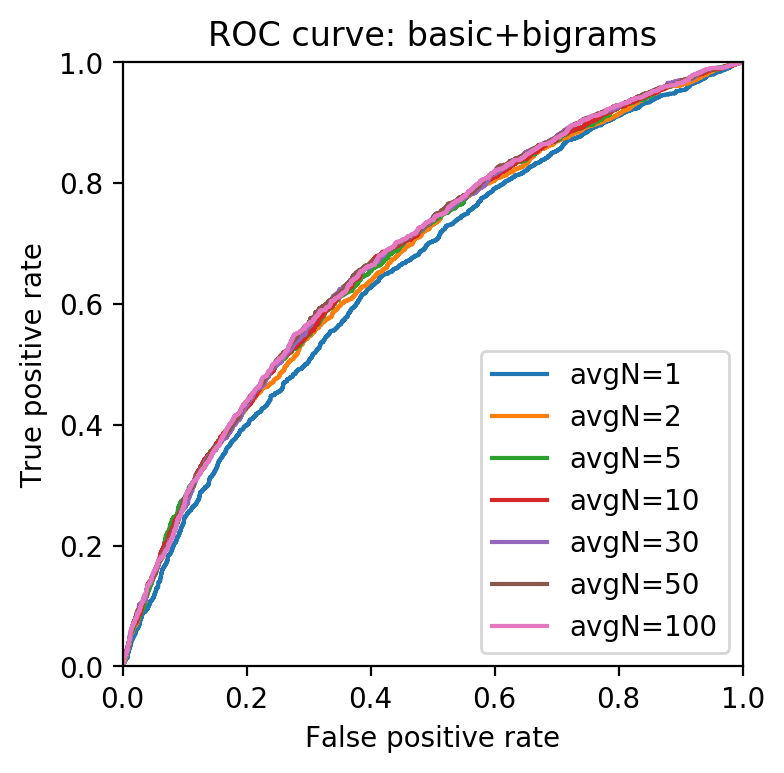

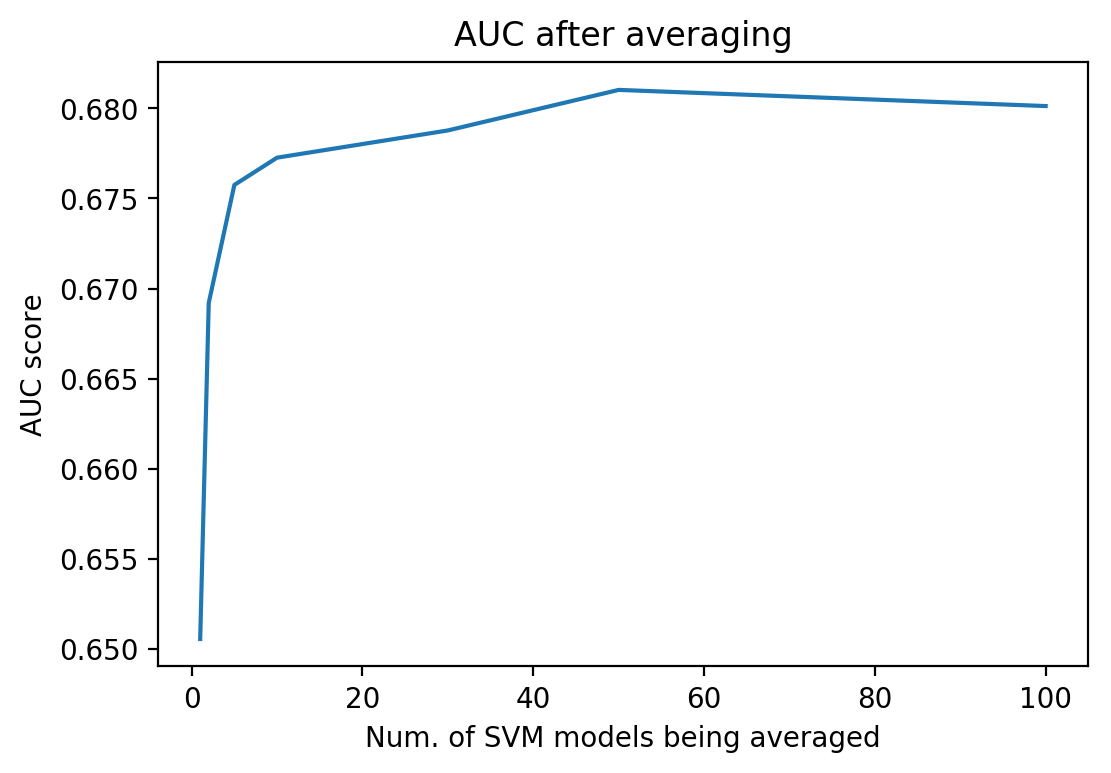

In [171]:
evaluate_model(b_models, X_valid_bn, y_valid, 'basic+bigrams', ns=[1, 2, 5, 10, 30, 50, 100])

# Permutation Testing

This is based on statistical permutation testing from [last semester](http://www.cims.nyu.edu/~cfgranda/pages/DSGA1002_fall16/material/hypothesis_testing.pdf). Basically, compute the distance between two sentence averages. Then, swap the words between the sentences (in my implementation, the lengths are kept constant) and recalculate the distance. The feature value is the probability that the distance of the permuted sentences is greater than the original distance (p-value).

To make this a feature, instead of computing an overall distance between two vectors, I kept each dimension separate. So you get $d$ p-values instead of just one.

In [393]:
# Add some permutation.
permute = [vector_multiply, vector_permute]
X_train_bp = X_train_no_bigrams[:,:500]
X_valid_bp = X_valid_no_bigrams[:,:500]
print(X_train_bp.shape)

(20000, 500)


In [394]:
bpnrm = Normalizer()
X_train_bpn = bnrm.fit_transform(X_train_bp)
X_valid_bpn = bnrm.transform(X_valid_bp)

bp_models = train_svms(X_train_bpn, bag_num=100, examples_per_bag=1000, C=0.2)

Model: 0 [13037, 13162, 1583, 7149, 3258, 5348, 18132, 18690, 12535, 13647]
Model: 1 [12194, 3649, 6885, 5180, 1351, 14342, 6677, 13798, 12756, 11928]
Model: 2 [2849, 17257, 11690, 3173, 7732, 4685, 4872, 16319, 7745, 415]
Model: 3 [16556, 2882, 175, 7598, 18555, 19562, 2818, 11075, 13312, 15926]
Model: 4 [7655, 5778, 3930, 10984, 18829, 4776, 11473, 6521, 16790, 344]
Model: 5 [10085, 4930, 1089, 13667, 19750, 18326, 5862, 11158, 11972, 4438]
Model: 6 [15981, 13164, 1368, 10376, 16598, 1908, 1303, 13551, 16683, 10006]
Model: 7 [8409, 8086, 10373, 11495, 428, 15101, 727, 7640, 6645, 6134]
Model: 8 [7326, 16588, 475, 2859, 14725, 12811, 14606, 11678, 16426, 18542]
Model: 9 [17540, 14145, 88, 5227, 10780, 13501, 14217, 8408, 3167, 13115]
Model: 10 [1352, 11437, 2602, 16873, 1463, 5489, 12650, 17924, 13640, 14026]
Model: 11 [19831, 18640, 18444, 17721, 15956, 19780, 999, 15377, 12334, 3038]
Model: 12 [12732, 2769, 13763, 5380, 17923, 8080, 16030, 14077, 5988, 18718]
Model: 13 [9480, 16356,

In [395]:
bp_models[0].coef_[0].shape

(500,)

avgN=1 AUC: 0.74831357413
avgN=10 AUC: 0.778208867884
avgN=20 AUC: 0.781531866057
avgN=30 AUC: 0.780811224135
avgN=40 AUC: 0.781036596645
avgN=50 AUC: 0.781130802697
avgN=100 AUC: 0.781609225042


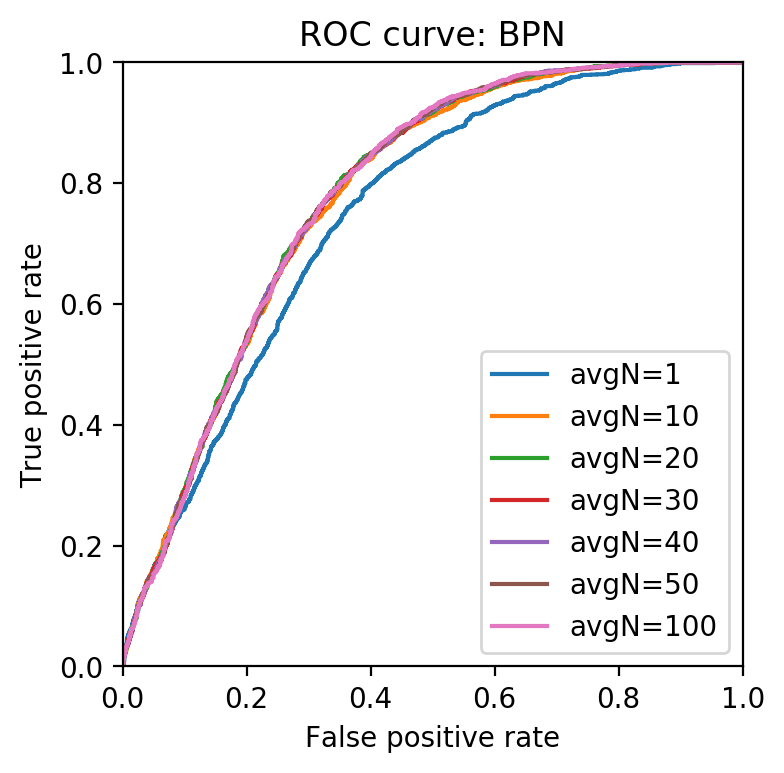

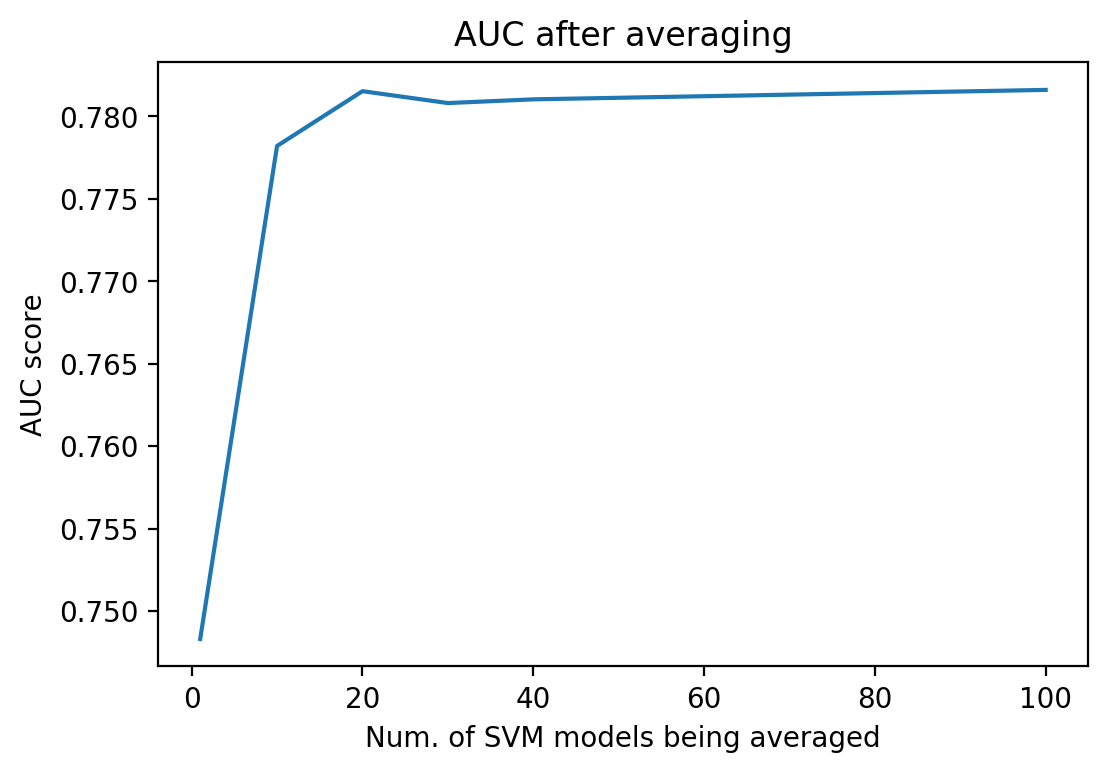

In [396]:
evaluate_model(bp_models, X_valid_bpn, y_valid, 'BPN', ns=[1, 10, 20, 30, 40, 50, 100])

# KL Divergence

KLD is a measure of the difference between probability distributions.

Imagine a sentence as a Gaussian that spits out words in a cloud. This Gaussian has a mean and variance.

This is another distance measure we can plug in between two sentences. Let's treat the word vectors as individual 1-dimensional gaussians, and compute pairwise KLD between q1 and q2. KLD is asymmetric, so we can run it twice.

The formula is ([source](http://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)): Let $p(x) = N(\mu_1, \sigma_1)$ and $q(x) = N(\mu_2, \sigma_2)$.
\begin{align}
KL(p, q) &= - \int p(x) \log q(x) dx + \int p(x) \log p(x) dx\\\\
&=\frac{1}{2} \log (2 \pi \sigma_2^2) + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2} (1 + \log 2 \pi \sigma_1^2)\\\\
&= \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2}
\end{align}

In [281]:
def mean_stdev(words, base_std = 0.001):
    not_none = lambda x: not x is None
    wvs = filter(not_none, [get_word_embedding(q) for q in words])
    pack = np.stack(wvs, axis=1)
    return np.mean(pack, axis=1), (np.std(pack, axis=1) + base_std)

def kld(q1, q2):
    mu1, sig1 = mean_stdev(q1)
    mu2, sig2 = mean_stdev(q2)
    
    return np.log(sig2 / sig1) + \
        (np.square(sig1) + np.square(mu1 - mu2)) / \
        (2 * np.square(sig2)) - 0.5

def whatever(q1, q2):
    # Because why not.
    k1 = kld(q1, q2)
    k2 = kld(q2, q1)
    # ReLU!
    l = np.concatenate([k1, k2, k1 * k2])
    return np.sqrt(np.maximum(l, 0))

whatever(clean[1234][0], clean[1234][1])[170:210]

array([ 0.47715307,  0.15962254,  0.20990242,  0.49703245,  0.36431021,
        0.36008864,  0.20473057,  0.14846497,  0.29426099,  0.18053515,
        0.34726894,  0.12680716,  0.0765425 ,  0.265819  ,  0.10516096,
        0.14799474,  0.17782556,  0.47116594,  0.75043046,  0.12218866,
        0.48779282,  0.17162056,  0.21493263,  0.46233854,  0.95161425,
        0.2445686 ,  0.56733546,  0.14876022,  0.23113491,  0.3150586 ,
        0.04033568,  0.06031513,  0.05753649,  0.19315067,  0.06084987,
        0.27205082,  0.01535002,  0.0013855 ,  0.09623058,  0.04721286])

In [272]:
wh = [whatever]
X_train_whatever = vectorize(train_set, wh)
X_valid_whatever = vectorize(valid_set, wh)
print(X_train_whatever.shape)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
2000
4000
(20000, 400)


In [155]:
X_train_kitchensink = np.concatenate([X_train_bp, X_train_whatever], axis=1)
X_valid_kitchensink = np.concatenate([X_valid_bp, X_valid_whatever], axis=1)
print(X_train_kitchensink.shape)

(20000, 1000)


In [160]:
kn = Normalizer()
X_train_kn = kn.fit_transform(X_train_kitchensink)
X_valid_kn = kn.transform(X_valid_kitchensink)

kitchensink_svms = train_svms(X_train_kn, bag_num=100, examples_per_bag=1000, C=0.2)

Model: 0 [7892, 4668, 14783, 8657, 18415, 17477, 16077, 1172, 4777, 12504]
Model: 1 [19061, 4068, 9381, 19647, 1011, 10215, 18306, 4986, 12177, 12640]
Model: 2 [15602, 16558, 14438, 2585, 9596, 3173, 9182, 9082, 9051, 16743]
Model: 3 [19436, 3345, 13282, 18593, 13957, 2363, 15042, 10489, 14917, 11937]
Model: 4 [303, 1839, 3723, 12262, 3374, 276, 2385, 16064, 2811, 5037]
Model: 5 [1282, 6981, 15732, 8490, 4466, 1485, 9335, 17188, 18759, 2783]
Model: 6 [190, 7683, 1135, 6836, 19700, 9559, 505, 10455, 8547, 17448]
Model: 7 [11539, 7813, 17698, 3232, 18416, 8400, 7971, 11310, 10218, 17563]
Model: 8 [18554, 5061, 15082, 14176, 12174, 5854, 9364, 1210, 19241, 10689]
Model: 9 [4351, 15917, 9655, 3168, 6458, 9391, 17004, 17166, 2190, 1764]
Model: 10 [3905, 19817, 12730, 18729, 19589, 17853, 16355, 13364, 13959, 1205]
Model: 11 [15168, 11352, 10831, 4062, 13056, 17327, 2298, 13282, 4104, 19222]
Model: 12 [11436, 16149, 18425, 18412, 11229, 8942, 2186, 14302, 6299, 9179]
Model: 13 [484, 1423, 16

In [158]:
kitchensink_svms[0].coef_[0].shape

(1000,)

avgN=1 AUC: 0.737747540156
avgN=10 AUC: 0.764337714259
avgN=20 AUC: 0.765513570829
avgN=30 AUC: 0.764936300893
avgN=40 AUC: 0.764293361774
avgN=50 AUC: 0.764543489158
avgN=100 AUC: 0.765719345729


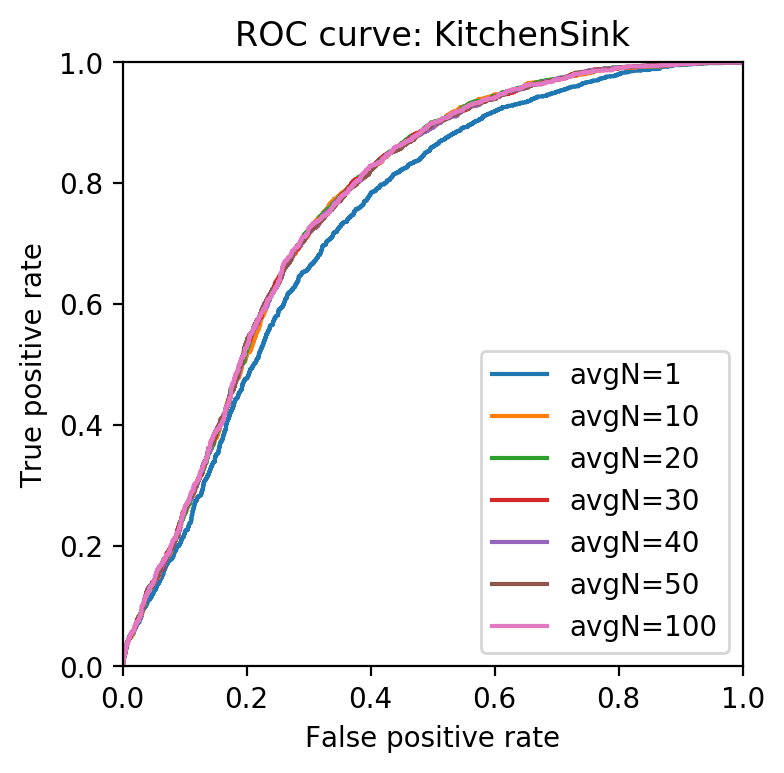

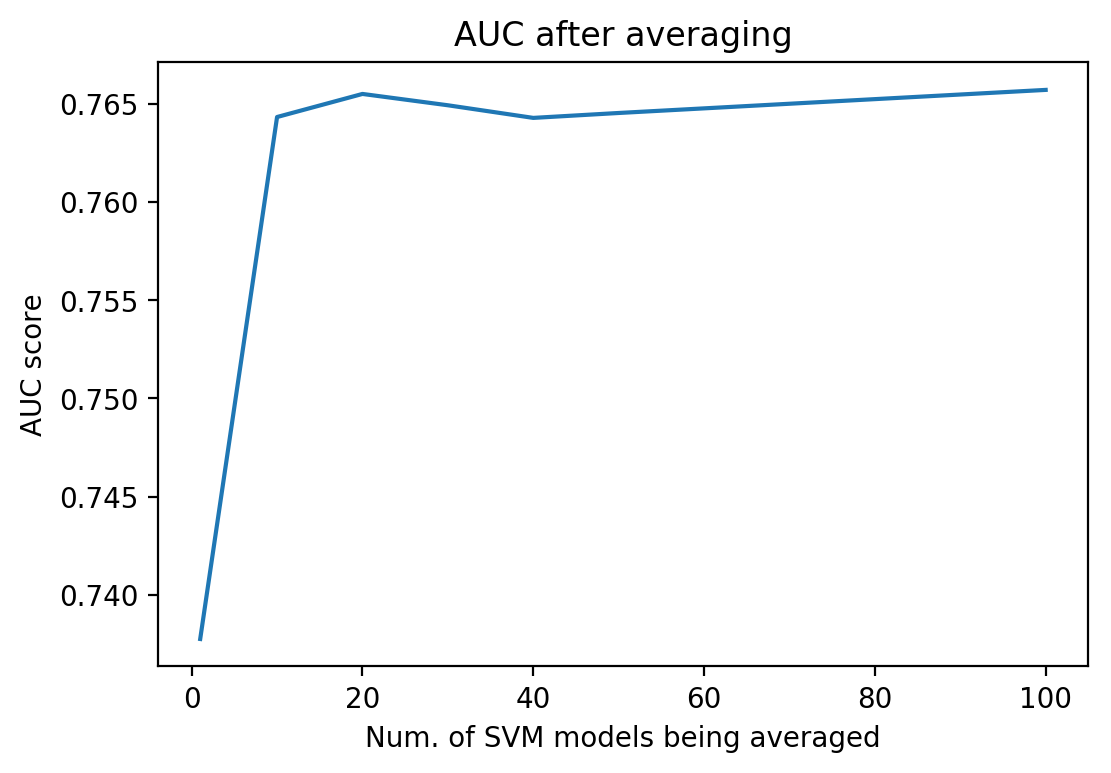

In [161]:
evaluate_model(kitchensink_svms, X_valid_kn, y_valid, 'KitchenSink', ns=[1, 10, 20, 30, 40, 50, 100])

# Remove Bigrams

The bigram features didn't seem to help. What if we just remove them?

In [378]:
no_bigrams = [vector_multiply, vector_permute, whatever]
X_train_no_bigrams = vectorize(train_set, no_bigrams)
X_valid_no_bigrams = vectorize(valid_set, no_bigrams)
print(X_train_no_bigrams.shape)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
2000
4000
(20000, 800)


In [379]:
X_train_no_bigrams_reversed = vectorize(train_set, no_bigrams, reverse=True)
X_valid_no_bigrams_reversed = vectorize(valid_set, no_bigrams, reverse=True)
print(X_train_no_bigrams_reversed.shape)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
2000
4000
(20000, 800)


In [380]:
nob = Normalizer()
X_train_nob = nob.fit_transform(X_train_no_bigrams)
X_valid_nob = nob.transform(X_valid_no_bigrams)

models_no_bigrams = train_svms(X_train_nob, bag_num=100, examples_per_bag=1000, C=0.2)

Model: 0 [3137, 4261, 5193, 3362, 11782, 16726, 15091, 656, 4100, 4219]
Model: 1 [13571, 2690, 7085, 17012, 14980, 7138, 464, 18389, 19265, 12820]
Model: 2 [684, 16963, 18913, 4162, 6523, 8086, 1909, 15587, 18443, 14736]
Model: 3 [6948, 1290, 10761, 14911, 16628, 9142, 129, 9941, 17820, 19595]
Model: 4 [16153, 13510, 19787, 14783, 9547, 4288, 17997, 4584, 667, 10792]
Model: 5 [16585, 7620, 15663, 12315, 514, 3682, 10031, 7118, 646, 12289]
Model: 6 [8148, 2075, 17442, 6335, 10703, 8466, 17165, 5540, 2353, 3956]
Model: 7 [5929, 16756, 8543, 14068, 9712, 10585, 13194, 5913, 17424, 7559]
Model: 8 [6968, 19772, 13219, 6826, 14675, 17195, 4555, 2611, 3455, 2234]
Model: 9 [5847, 7996, 8683, 14572, 2112, 12072, 17501, 11311, 3786, 1096]
Model: 10 [11736, 9063, 9565, 15410, 11618, 13108, 5452, 17633, 18734, 10576]
Model: 11 [3745, 11065, 10052, 12648, 18116, 18925, 16124, 10208, 9454, 13320]
Model: 12 [12828, 8968, 10812, 18197, 818, 12908, 13347, 6020, 2572, 9389]
Model: 13 [1294, 16330, 10449

avgN=30 AUC: 0.788426786425
avgN=31 AUC: 0.788295104242
avgN=32 AUC: 0.788421972977
avgN=33 AUC: 0.788178034312
avgN=34 AUC: 0.788185082575
avgN=35 AUC: 0.788307309771
avgN=36 AUC: 0.788260034836
avgN=37 AUC: 0.788390513657
avgN=38 AUC: 0.788476983811
avgN=39 AUC: 0.788232013692


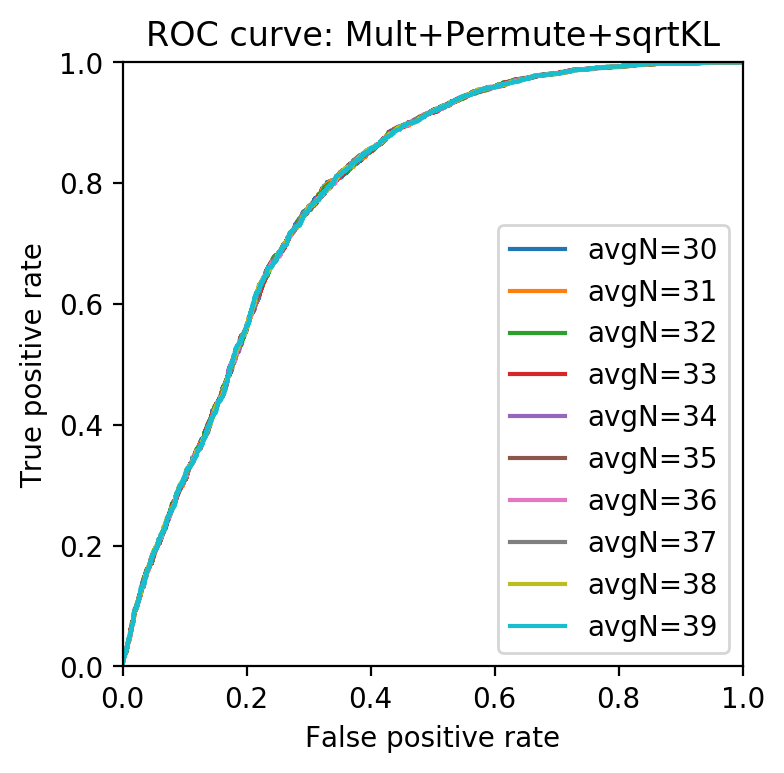

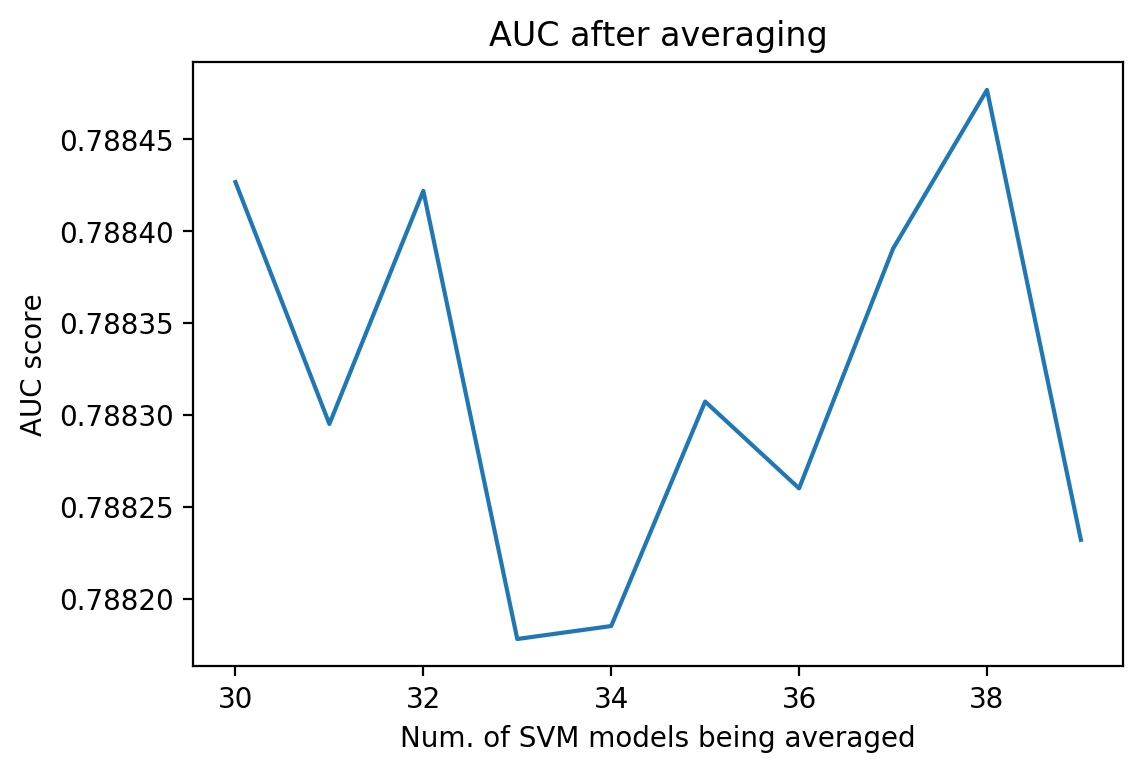

In [389]:
evaluate_model(models_no_bigrams, X_valid_nob, y_valid, 'Mult+Permute+sqrtKL', ns=range(30, 40))

In [290]:
# This is actually pretty interesting. Let's save it.
kitchen_sink = {
    'X_train': X_train_no_bigrams,
    'X_valid': X_valid_no_bigrams,
    'X_train_reversed': X_train_no_bigrams_reversed,
    'X_valid_reversed': X_valid_no_bigrams_reversed,
    'y_train': y_train,
    'y_valid': y_valid
}
pickle.dump(kitchen_sink, open('../data/kitchen_sink.pickle', 'wb'))

# Reversed Model

Duplicate questions are symmetric. So we should train on (q1, q2) and (q2, q1), as well as averaging during test.

In [382]:
X_train_no_bigrams_symmetric = np.concatenate([X_train_no_bigrams, X_train_no_bigrams_reversed])
print(X_train_no_bigrams_symmetric.shape)

(40000, 800)


In [383]:
norm_symm = Normalizer()
X_train_symm = norm_symm.fit_transform(X_train_no_bigrams_symmetric)
y_train_symm = np.concatenate([y_train, y_train])
X_valid_symm = norm_symm.transform(X_valid_no_bigrams) # Keep validation set the same
X_valid_symm_rev = norm_symm.transform(X_valid_no_bigrams_reversed) # Keep validation set the same

symmetric_model = train_svms(X_train_symm, y=y_train_symm, bag_num=100, examples_per_bag=2000, C=0.2)

Model: 0 [35516, 17040, 9713, 282, 38502, 11460, 19893, 2115, 37393, 7423]
Model: 1 [28560, 9912, 7407, 30556, 8803, 12455, 8998, 34822, 15412, 24817]
Model: 2 [35537, 29979, 11584, 16170, 36707, 26334, 17712, 19521, 22916, 38779]
Model: 3 [10156, 34176, 39433, 36133, 25285, 2400, 36600, 22041, 10885, 37503]
Model: 4 [26025, 39595, 9095, 37729, 26550, 26938, 39516, 20812, 35744, 12997]
Model: 5 [532, 4853, 26625, 14398, 28587, 26206, 24720, 18761, 6509, 4720]
Model: 6 [11174, 2261, 20291, 1426, 36294, 34964, 14827, 2776, 33231, 16887]
Model: 7 [4497, 11298, 35433, 28085, 11601, 21997, 20586, 37425, 23970, 38932]
Model: 8 [35359, 25539, 14974, 24674, 29258, 37235, 16003, 13232, 37047, 30302]
Model: 9 [36394, 11685, 25464, 27245, 33168, 3583, 29531, 7763, 9392, 8599]
Model: 10 [1978, 31662, 14456, 17216, 5893, 36309, 20955, 39473, 21139, 3582]
Model: 11 [15167, 1126, 1115, 34940, 4061, 10820, 12324, 35174, 38064, 2352]
Model: 12 [20013, 30439, 18638, 17379, 25361, 38342, 37085, 37533, 29

In [384]:
# Get the symmetric model's results.
decision_one = lambda svm, x: svm.decision_function(x)
decisions_array   = np.stack([decision_one(svm, X_valid_symm) for svm in symmetric_model], axis=1)
decisions_array_r = np.stack([decision_one(svm, X_valid_symm_rev) for svm in symmetric_model], axis=1)

symm_array = np.stack([decisions_array, decisions_array_r], axis=2)
print(symm_array.shape)

(5000, 100, 2)


(5000, 100)
avgN=1 AUC: 0.755198523784
avgN=2 AUC: 0.774202360102
avgN=3 AUC: 0.779980560547
avgN=4 AUC: 0.781641200089
avgN=5 AUC: 0.782547503574
avgN=6 AUC: 0.785185960685
avgN=7 AUC: 0.786018343362
avgN=8 AUC: 0.78781633808
avgN=9 AUC: 0.787604374461
avgN=10 AUC: 0.789184216842
avgN=11 AUC: 0.788651987026
avgN=12 AUC: 0.787566038787
avgN=13 AUC: 0.786670393651
avgN=14 AUC: 0.786370584607
avgN=15 AUC: 0.786232885614
avgN=16 AUC: 0.786333796112
avgN=17 AUC: 0.785614873279
avgN=18 AUC: 0.785394658035
avgN=19 AUC: 0.785465484484
avgN=20 AUC: 0.785030211262
avgN=21 AUC: 0.785265726394


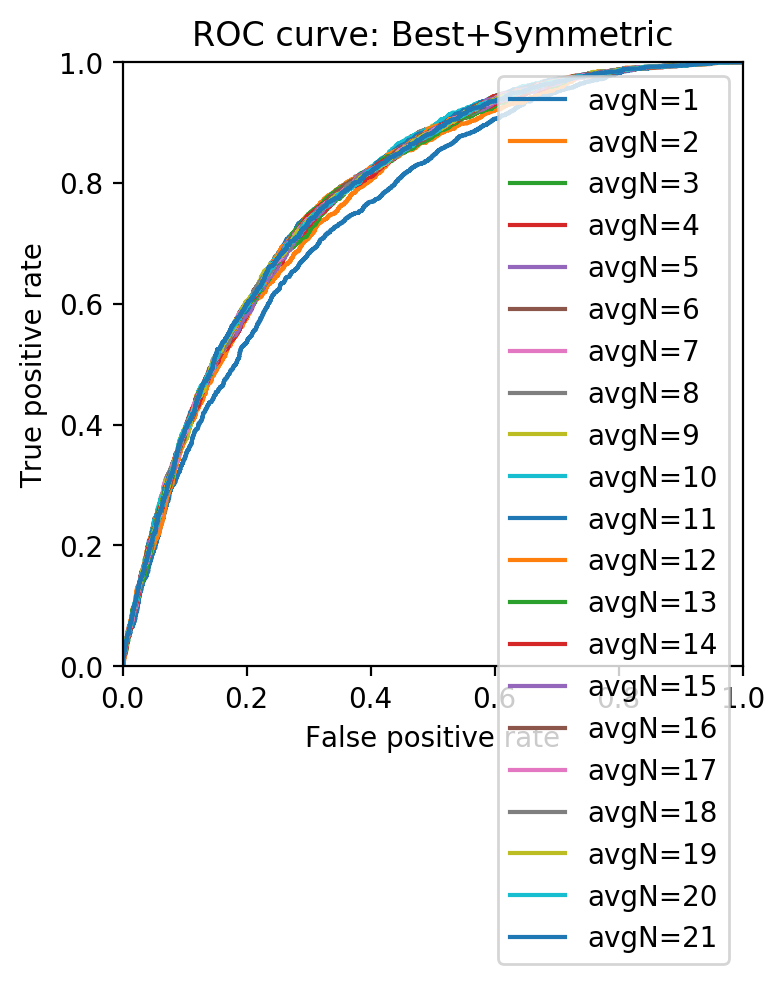

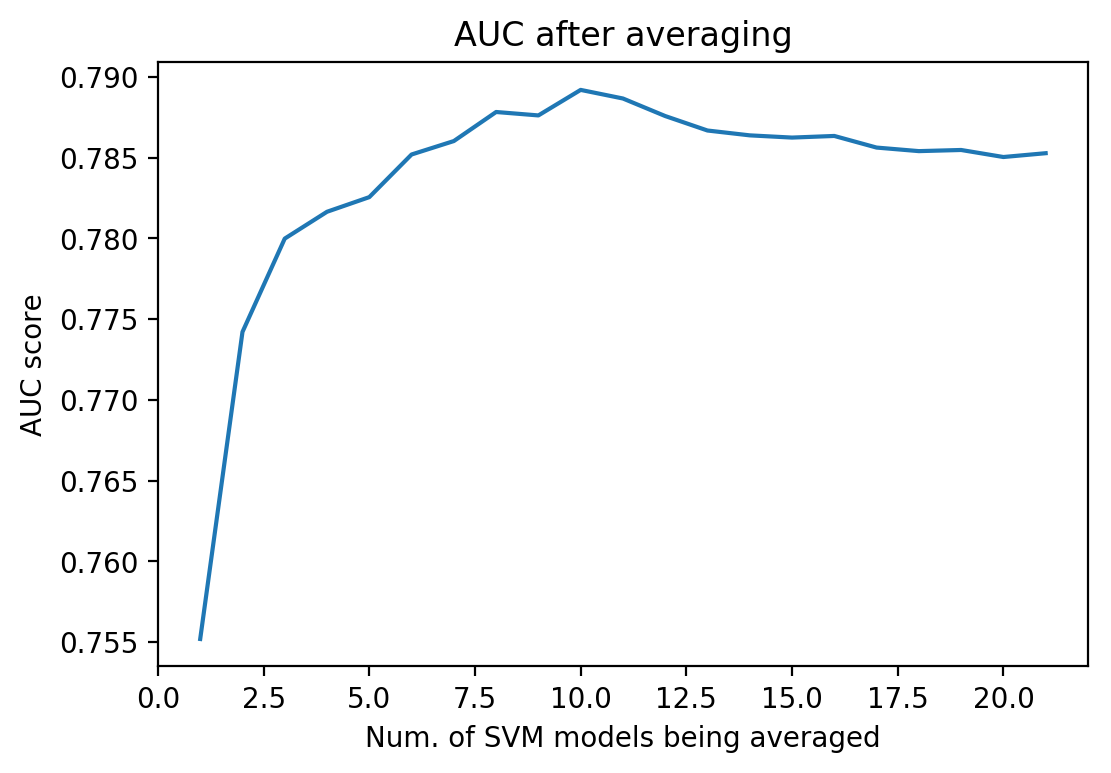

In [387]:
symm_results = np.mean(symm_array, axis=2)
print(results.shape)
evaluate_results(symm_results, y_valid, title='Best+Symmetric', ns=range(1,22))

# Summary

Here's what helped:
1. Pasting x1, x2 and x1 * x2 together
1. Doing a permutation test on the words.
  1. Worth noting that even with just 100 dimensions (the other schemes add 300 dimensions),
     doing this raised AUC by 4%, basically the same gain as going from a single model to 100x bagging.
  1. There's some randomness to the process, so set the random seed so you get a repeatable result.
  1. These are the slowest features to compute. Optimizing to do in-place matrix ops
     and some use of globals helps.
1. Sqrt(KL divergence) works even though KL didn't. There's not a lot of AUC increase but accuracy went up significantly (~1%).

Didn't help:
1. Bigrams, at least the way I implemented it here (vector for word $x$ * vector for word $x + 1$ actively confused the classifier. Removing bigrams from kitchen sink model gained 2%.
1. Reversing the arguments (q1 and q2) didn't help AUC. Averaging the results of applying the function in reverse also didn't help. However, looking at the ROC curves, it looks more symmetric and the model does better when precision has to be kept high.
  1. Looks like it helps if the permutation features are squared.
1. KL divergence (AUC goes up, but didn't really change the curve significantly)

For SVMs, the bigrams don't really give any useful information.

Next, maybe feed this thru a MLP. Or a Factor model.

## Dataset

I compiled a 20k dataset set with all these features precomputed:
1. [``kitchen_sink.pickle``](https://drive.google.com/open?id=0B3PT5wpPFOx7SXdCdkIwOW9keVE) has the 700$-d$ vectors for training and validation and their labels. It has features from just basic recombination, permutation testing and square-root KL-divergence.
1. [``train_small.pickle``](https://drive.google.com/open?id=0B3PT5wpPFOx7Qm5QbU1iMS1vQ3M) has the tokenized, lowercased words for the training set found in ``kitchen_sink``.
   It has the same order as the training examples in ``kitchen_sink``.
1. [``valid_small.pickle``](https://drive.google.com/open?id=0B3PT5wpPFOx7bnQzNndnQ2NFSk0) has the tokenized, lowercased words for the validation set found in ``kitchen_sink``.
   It has the same order as the validation examples in ``kitchen_sink``.

basic AUC: 0.72056353098
bigrams AUC: 0.679509117702
permute AUC: 0.781609225042
perm^2+sqrtKL AUC: 0.788111505585
prm^2+sqrtKL+symmetric AUC: 0.785763230621


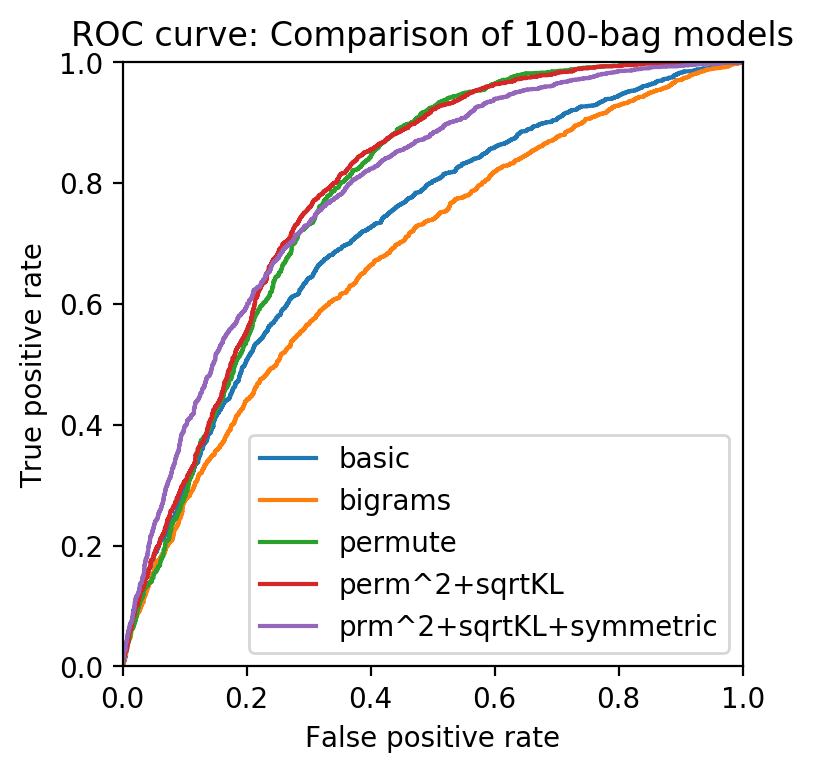

In [397]:
# Get ROC curves of all models in one plot
decision_one = lambda svm, x: svm.decision_function(x)

basic = np.stack([decision_one(svm, X_valid) for svm in models], axis=1)
bigrams = np.stack([decision_one(svm, X_valid_bn) for svm in b_models], axis=1)
permutation = np.stack([decision_one(svm, X_valid_bpn) for svm in bp_models], axis=1)
pkl = np.stack([decision_one(svm, X_valid_nob) for svm in models_no_bigrams], axis=1)
# symm_results

plt.figure(figsize=(4,4))

plt.title('ROC curve: Comparison of 100-bag models')
configs = [
    (basic, 'basic'),
    (bigrams, 'bigrams'),
    (permutation, 'permute'),
    (pkl, 'perm^2+sqrtKL'),
    (symm_results, 'prm^2+sqrtKL+symmetric')
]
for decisions_array, name in configs:
    # n = how many SVMs to average over
    decision_fn = np.mean(decisions_array, axis=1)
    evaluate(y_valid, decision_fn, name)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

single max: 0.6618
basic max: 0.6932
permute max: 0.717
symmetric max: 0.729
permute-KL max: 0.7266


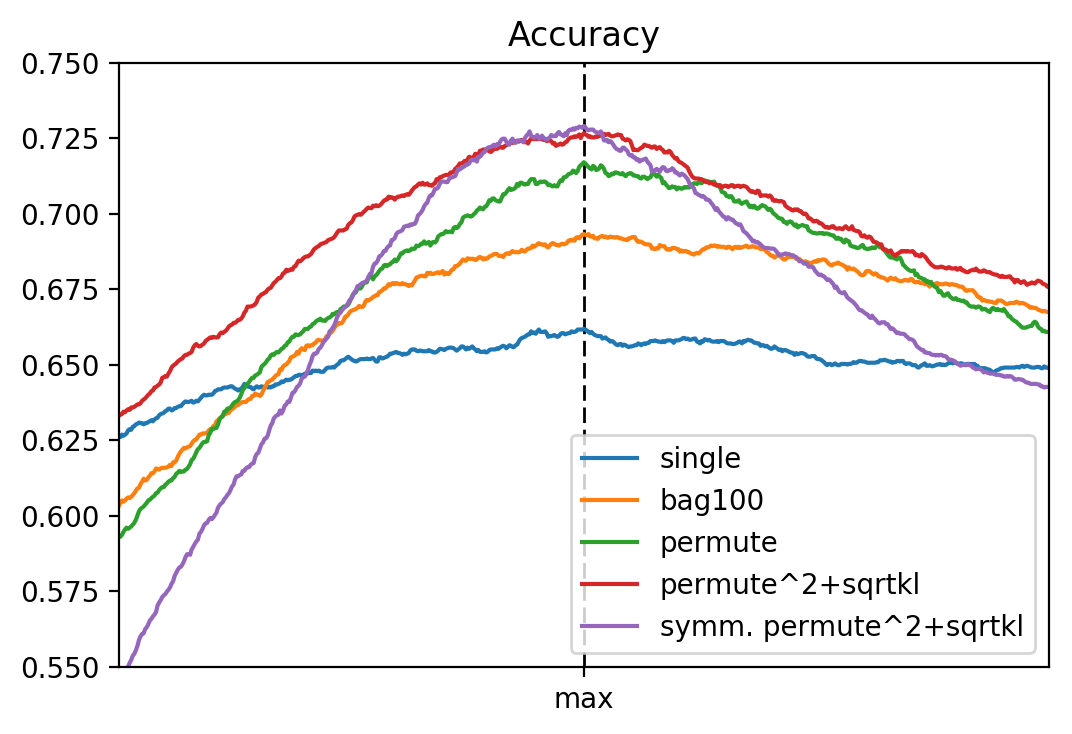

In [403]:
from sklearn.metrics import accuracy_score

z = np.arange(-1, 0.2, 0.001)


single_pred = basic[:,0]
basic_pred = np.mean(basic, axis=1)
zsingle = 4 * z # (Shift this so it lines up nicely. It's the same function anyway.)
zbasic = 4 * (z - 0.2)


symm_pred = np.mean(symm_results, axis=1)
pkl_pred = np.mean(pkl, axis=1)
permute_pred = np.mean(permutation, axis=1)

single_acc = [accuracy_score(y_valid, single_pred > x) for x in zsingle]
single_argmax = np.argmax(single_acc)
single_z = z[single_argmax]
print('single max:', max(single_acc))

basic_acc = [accuracy_score(y_valid, basic_pred > x) for x in zbasic]
basic_z = z[np.argmax(basic_acc)]
print('basic max:', max(basic_acc))

permute_acc = [accuracy_score(y_valid, permute_pred > x) for x in z]
permute_z = z[np.argmax(permute_acc)]
print('permute max:', max(permute_acc))

sym_acc = [accuracy_score(y_valid, symm_pred > x) for x in z]
sym_z = z[np.argmax(sym_acc)]
print('symmetric max:', max(sym_acc))

pkl_acc = [accuracy_score(y_valid, pkl_pred > x) for x in z]
pkl_argmax = np.argmax(pkl_acc)
pkl_z = z[pkl_argmax]
print('permute-KL max:', max(pkl_acc))

plt.figure()
# Shift the accuracies so the maximum occurs at 0.0
plt.axvline(x=0, linewidth=1, color='k', linestyle='dashed')
plt.plot(z - single_z, single_acc, label='single')
plt.plot(z - basic_z, basic_acc, label='bag100')
plt.plot(z - permute_z, permute_acc, label='permute')
plt.plot(z - pkl_z, pkl_acc, label='permute^2+sqrtkl')
plt.plot(z - sym_z, sym_acc, label='symm. permute^2+sqrtkl')
plt.title('Accuracy')
plt.legend(loc='best')
plt.xlim(-0.3, 0.3)
plt.ylim(0.55, 0.75)
plt.xticks([0], ['max'])
plt.show()